In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from scipy.signal import savgol_filter

In [2]:
# df = pd.read_csv('data/RAW_A9_01/a9_clean.csv', header=None)
# df = pd.read_csv('data/RAW_A9_02/a9_02_clean.csv', header=None)
# df = pd.read_csv('data/RAW_A9_02/a9_02_above.csv', header=None)
df = pd.read_csv('data/RAW_A9_03/a9_03_clean.csv', header=None)

# df = pd.read_csv('data/train_data_UU.csv', header=None)

In [3]:
print("total shape + label:", df.shape)

total shape + label: (167, 502)


In [4]:
df.replace('a', 'nothing', inplace=True)
df.replace('b', 'passing', inplace=True)
df.replace('c', 'touching', inplace=True)

In [5]:
# 平均切分各個標籤至train test中

TRAIN_SET_RATE = 0.8  # Rate to seperate train set and test set

labelA =  df[df.iloc[:, -1] == 'nothing']
labelB =  df[df.iloc[:, -1] == 'passing']
labelC =  df[df.iloc[:, -1] == 'touching']
assert len(labelA) + len(labelB) + len(labelC) == len(df)
print("[ Labels ]")
print("labelA shape:", labelA.shape)
print("labelB shape:", labelB.shape)
print("labelC shape:", labelC.shape)
print()

sfA = shuffle(labelA)
trainA, testA = sfA[:int(len(sfA) * TRAIN_SET_RATE)], sfA[int(len(sfA) * TRAIN_SET_RATE):]
trainA = trainA[:50]  # shrimp trainA size

sfB = shuffle(labelB)
trainB, testB = sfB[:int(len(sfB) * TRAIN_SET_RATE)], sfB[int(len(sfB) * TRAIN_SET_RATE):]

sfC = shuffle(labelC)
trainC, testC = sfC[:int(len(sfC) * TRAIN_SET_RATE)], sfC[int(len(sfC) * TRAIN_SET_RATE):]

print("[ Labels in Train & Test sets ]")
print("trainA shape:", trainA.shape, ", testA shape:", testA.shape)
print("trainB shape:", trainB.shape, ", testB shape:", testB.shape)
print("trainC shape:", trainC.shape, ", testC shape:", testC.shape)
print()


train_set = pd.concat([trainA, trainB, trainC])
train_set = shuffle(train_set)
test_set = pd.concat([testA, trainB, testC])
test_set = shuffle(test_set)
print("[ Train & Test sets ]")
print("train set:", len(train_set), ", test set:", len(test_set))
print()
    
x_train, y_train = train_set.iloc[:, 0:-1], train_set.iloc[:, -1]
x_test, y_test = test_set.iloc[:, 0:-1], test_set.iloc[:, -1]

[ Labels ]
labelA shape: (77, 502)
labelB shape: (16, 502)
labelC shape: (74, 502)

[ Labels in Train & Test sets ]
trainA shape: (50, 502) , testA shape: (16, 502)
trainB shape: (12, 502) , testB shape: (4, 502)
trainC shape: (59, 502) , testC shape: (15, 502)

[ Train & Test sets ]
train set: 121 , test set: 43



In [6]:
LABELS = ['nothing', 'passing', 'touching']

y_test_index = y_test.index

# LabelEncoder
le = LabelEncoder()
le.fit(LABELS)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


# OneHot
# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Standardize
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

# savgol
if isinstance(x_train, pd.DataFrame):
    for i in range(len(x_train)):
        row = x_train.iloc[i]
        x_train.iloc[i] = savgol_filter(row, 85, 2)
    for i in range(len(x_test)):
        row = x_test.iloc[i]
        x_test.iloc[i] = savgol_filter(row, 85, 2)
else:
    for i in range(len(x_train)):
        row = x_train[i]
        x_train[i] = savgol_filter(row, 85, 2)
    for i in range(len(x_test)):
        row = x_test[i]
        x_test[i] = savgol_filter(row, 85, 2)

In [7]:
epochs = 150
batch_size = 10
verbose = 0  # verbose : 0, 1或2。日誌顯示模式。0 =安靜模式, 1 =進度條, 2 =每輪一行。
time_step = 1
feature_dim = x_train.shape[1]

# reshape input to be 3D [samples, timesteps, features]
if isinstance(x_train, np.ndarray):
    x_train_reshape = x_train.reshape((x_train.shape[0], time_step, x_train.shape[1]))
    x_test_reshape = x_test.reshape((x_test.shape[0], time_step, x_test.shape[1]))
else:
    x_train_reshape = x_train.values.reshape((x_train.shape[0], time_step, x_train.shape[1]))
    x_test_reshape = x_test.values.reshape((x_test.shape[0], time_step, x_test.shape[1]))
print("[ Reshape ]")
print("train X:", x_train_reshape.shape, ", train Y:", y_train.shape)
print("test X:", x_test_reshape.shape, ", test Y:", y_test.shape)
print()

model = Sequential()
model.add(LSTM(64, input_shape=(time_step, feature_dim)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(40))
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # out_layer
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
# model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])


[ Reshape ]
train X: (121, 1, 501) , train Y: (121, 3)
test X: (43, 1, 501) , test Y: (43, 3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                144896    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 123       
Total params: 158,499
Train

## Use test to validate

In [8]:
# history = model.fit(x_train_reshape, 
#                     y_train, 
#                     batch_size=batch_size, 
#                     epochs=epochs, 
#                     verbose=verbose, 
#                     validation_data=(x_test_reshape, y_test))
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend() 
# plt.show() 

# history.history.keys()
# history.history['categorical_accuracy']

## validation_split

In [9]:
# validation_split=0.33

# history = model.fit(x_train_reshape,
#                     y_train,
#                     validation_split=validation_split, 
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=verbose)
# _, accuracy = model.evaluate(x_test_reshape, y_test)

# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

# print(accuracy)

## KFOLD

In [10]:
seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(x_train_reshape, y_train.argmax(1)):
    # create model
    model = Sequential()
    model.add(LSTM(64, input_shape=(time_step, feature_dim)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(40))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))  # out_layer
    
    # Compile model
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
    
    # Fit the model
    model.fit(x_train_reshape[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    
    # evaluate the model
    scores = model.evaluate(x_train_reshape[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

categorical_accuracy: 84.62%
categorical_accuracy: 83.33%
categorical_accuracy: 91.67%
categorical_accuracy: 91.67%
categorical_accuracy: 91.67%
categorical_accuracy: 58.33%
categorical_accuracy: 75.00%
categorical_accuracy: 91.67%
categorical_accuracy: 83.33%
categorical_accuracy: 83.33%
83.46% (+/- 9.87%)


## print report matrix

In [11]:
LABELS = ['nothing', 'passing', 'touching']
le = LabelEncoder()
le.fit(LABELS)

y_pred = model.predict(x_test_reshape, verbose=1)

# argmax(1) to get label
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
# y_pred = le.inverse_transform(y_pred_bool)

print(classification_report(y_test_bool, y_pred_bool, zero_division=1, target_names=LABELS))
print()
print("Confusion matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))
print()

2/2 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     nothing       0.88      0.94      0.91        16
     passing       0.91      0.83      0.87        12
    touching       1.00      1.00      1.00        15

    accuracy                           0.93        43
   macro avg       0.93      0.92      0.93        43
weighted avg       0.93      0.93      0.93        43


Confusion matrix:
[[15  1  0]
 [ 2 10  0]
 [ 0  0 15]]



In [12]:
print("Head:")
print(y_pred[:5])
print()

print("True:")
print(y_test_bool)
print()

print("Predict:")
print(y_pred_bool)
print()

Head:
[[1.8982279e-11 6.1784922e-10 1.0000000e+00]
 [9.9999988e-01 4.3993893e-12 1.3237116e-07]
 [9.9680114e-01 2.9463840e-03 2.5247401e-04]
 [9.9992561e-01 7.1530594e-05 2.8079919e-06]
 [7.7719325e-01 2.2270682e-01 9.9924233e-05]]

True:
[2 0 0 0 0 2 2 1 2 2 0 2 1 1 2 2 0 0 2 2 0 2 1 2 0 2 0 0 0 2 1 0 1 1 1 0 2
 1 1 1 1 0 0]

Predict:
[2 0 0 0 0 2 2 1 2 2 0 2 1 1 2 2 0 0 2 2 0 2 1 2 0 2 1 0 0 2 1 0 1 1 0 0 2
 1 1 0 1 0 0]



In [15]:
# ### Save model
from time import localtime, strftime

timestamp = strftime("%Y-%m-%d_%H-%M-%S", localtime())
model_name = "LSTM_" + timestamp + ".h5"
print(model_name)


model.save('model/' + model_name)

LSTM_2021-07-03_00-44-10.h5


## print mistake graphs

2/2 [==============================] - 0s 2ms/step
============== Row:026 Index:87 ============== (True:0 Predict:1 )


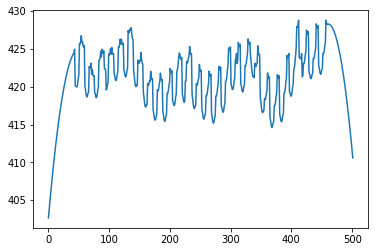

============== Row:034 Index:77 ============== (True:1 Predict:0 )


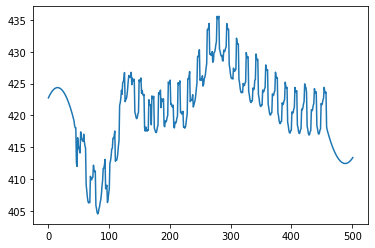

============== Row:039 Index:135 ============== (True:1 Predict:0 )


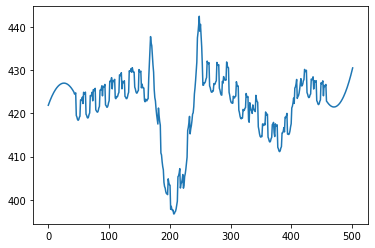

In [14]:
y_pred = model.predict(x_test_reshape, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)

x = np.linspace(0, len(df.iloc[0]) - 1, len(df.iloc[0]) - 1)
for i in range(len(y_test)):
    if y_pred_bool[i] != y_test_bool[i]:
        idx = y_test_index[i]
        print("============== Row:{:03d} Index:{} ============== (True:{} Predict:{} )".format(i, idx, y_test_bool[i], y_pred_bool[i]))
        y = df.iloc[idx, :-1]
        y = savgol_filter(y, 85, 2)
        plt.plot(x, y)
        plt.show()